In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
import joblib
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

In [5]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

In [6]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)

In [7]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] #+ ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [8]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [9]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [10]:
X = StandardScaler().fit_transform(X)
X = PCA(n_components=30).fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [12]:
def createModel():
    model = Sequential([
                    Dense(256, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [14]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=20, verbose=0)
    pred = model.predict(X_test)
    pred = pred >= 0.5
    f1 = f1_score(y_test, pred)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1


def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [15]:
crossValidation(K=10)

W1111 21:46:34.903512 20080 deprecation_wrapper.py:119] From C:\Users\91974\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1111 21:46:34.918472 20080 deprecation_wrapper.py:119] From C:\Users\91974\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1111 21:46:34.941410 20080 deprecation_wrapper.py:119] From C:\Users\91974\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1111 21:46:34.943407 20080 deprecation_wrapper.py:119] From C:\Users\91974\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1111 21:46:35.000252 20080 deprecation_wrapper.py:119] From C:\Users\91974\Anac

In [16]:
model = createModel()
model.fit(X_train, y_train, epochs=20, verbose=0)
pred = model.predict(X_test)
pred = pred >= 0.5

In [17]:
performance(y_test, pred)

F1 Score: 0.9873586161011311
Kappa Score: 0.9811841000239577
Accuracy Score: 0.9891110145347434
Confusion Matrix:
[[1529    5]
 [  14  742]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1534
           1       0.99      0.98      0.99       756

    accuracy                           0.99      2290
   macro avg       0.99      0.99      0.99      2290
weighted avg       0.99      0.99      0.99      2290



In [18]:
saveModel(model, "../model/nn-model-error.h5")

In [19]:
model = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model.fit(X, y)
perm = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(perm, feature_names = [f"Component {i+1}" for i in range(X.shape[1])])

Weight,Feature
0.1107 ± 0.0047,Component 4
0.0661 ± 0.0069,Component 8
0.0529 ± 0.0034,Component 1
0.0308 ± 0.0014,Component 6
0.0281 ± 0.0024,Component 17
0.0219 ± 0.0015,Component 14
0.0208 ± 0.0032,Component 9
0.0149 ± 0.0025,Component 2
0.0133 ± 0.0020,Component 21
0.0103 ± 0.0024,Component 10


In [20]:
perm.feature_importances_

array([0.05286064, 0.01487246, 0.0008935 , 0.11073642, 0.00769563,
       0.03081136, 0.00126819, 0.06609021, 0.02075227, 0.01026084,
       0.00265168, 0.00438103, 0.00273815, 0.021934  , 0.00325695,
       0.00146995, 0.02810203, 0.00809915, 0.00129702, 0.00377576,
       0.01334486, 0.0080415 , 0.00907912, 0.00570687, 0.0008935 ,
       0.00135466, 0.00149878, 0.00097997, 0.00276697, 0.00103761])

In [21]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray(TO_USE)[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

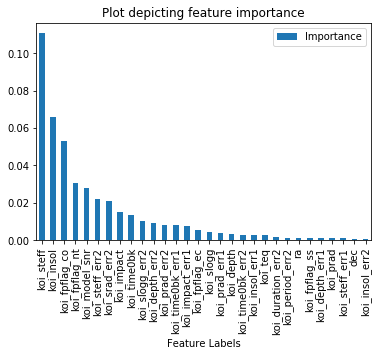

In [24]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.xlabel('Feature Labels')
plt.show()